#Deep Learning for Movie Recommendation

###Uninstall latest version of keras and tensorflow and installing older stable versions due to compatibility issues

In [ ]:
!pip uninstall keras
!pip uninstall tensorflow

In [ ]:
!pip install Keras==1.2.2
!pip install tensorflow==1.8.0

### Downloading Dataset, first check if the dataset already exists in files or not

In [ ]:
!wget https://raw.githubusercontent.com/khanhnamle1994/movielens/master/users.csv
!wget https://raw.githubusercontent.com/khanhnamle1994/movielens/master/ratings.csv
!wget https://raw.githubusercontent.com/khanhnamle1994/movielens/master/movies.csv

### Loading Dataset

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

# Reading ratings file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading ratings file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [ ]:
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

In [ ]:
K_FACTORS = 100 # The number of dimensional embeddings for movies and users

Creating a training and validation set and optimize the number of embeddings by minimizing the RMSE. Intuitively, the RMSE will decrease on the training set as the number of embeddings increases (because I'm approximating the original ratings matrix with a higher rank matrix). Here I create a training set by shuffling randomly the values from the original ratings dataset.

In [ ]:
# Create training set
shuffled_ratings = ratings.sample(frac=1.0)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)


# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print ('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print( 'Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [4469 4509 3767 ... 4063 3780 4407] , shape = (1000209,)
Movies: [2039 2789 3551 ... 3739  533 3470] , shape = (1000209,)
Ratings: [3 1 5 ... 4 4 5] , shape = (1000209,)


### Building the model

Created a sparse matrix factoring algorithm in Keras in CFModel. Here are the main components:
- A left embedding layer that creates a Users by Latent Factors matrix.
- A right embedding layer that creates a Movies by Latent Factors matrix.
- When the input to these layers are (i) a user id and (ii) a movie id, they'll return the latent factor vectors for the user and the movie, respectively.
- A merge layer that takes the dot product of these two latent vectors to return the predicted rating.

In [ ]:
import numpy as np
# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, Merge
from keras.models import Sequential

class CFModel(Sequential):

    # The constructor for the class
    def __init__(self, n_users, m_items, k_factors, **kwargs):
        # P is the embedding layer that creates an User by latent factors matrix.
        # If the intput is a user_id, P returns the latent factor vector for that user.
        P = Sequential()
        P.add(Embedding(n_users, k_factors, input_length=1))
        P.add(Reshape((k_factors,)))

        # Q is the embedding layer that creates a Movie by latent factors matrix.
        # If the input is a movie_id, Q returns the latent factor vector for that movie.
        Q = Sequential()
        Q.add(Embedding(m_items, k_factors, input_length=1))
        Q.add(Reshape((k_factors,)))

        super(CFModel, self).__init__(**kwargs)
        
        # The Merge layer takes the dot product of user and movie latent factor vectors to return the corresponding rating.
        self.add(Merge([P, Q], mode='dot', dot_axes=1))

    # The rate function to predict user's rating of unrated items
    def rate(self, user_id, item_id):
        return self.predict([np.array([user_id]), np.array([item_id])])[0][0]

I then compile the model using Mean Squared Error (MSE) as the loss function and the AdaMax learning algorithm.

In [ ]:
# Define model
model = CFModel(max_userid, max_movieid, K_FACTORS)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Train the Model

Now we need to train the model. This step will be the most-time consuming one. In my particular case, for our dataset with nearly 1 million ratings, almost 6,000 users and 4,000 movies, I trained the model in roughly 6 minutes per epoch (30 epochs ~ 3 hours) in the Colab Instance with the default configuration. I spitted the training and validataion data with ratio of 90/10.

In [ ]:
callbacks = [EarlyStopping(patience=2),
            ModelCheckpoint(filepath='model.h5',save_best_only=True)]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([Users, Movies], Ratings, nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)

In [ ]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 5 = 0.9415


### Predict the Ratings

The next step is to actually predict the ratings a random user will give to a random movie. Below I apply the freshly trained deep learning model for all the users and all the movies, using 100 dimensional embeddings for each of them.

In [ ]:
# Use the pre-trained model
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)
# Load weights
trained_model.load_weights('model.h5')

My random test user is has ID 2000. You can change this ID to see different results

In [ ]:
TEST_USER = 2000

In [ ]:
users[users['user_id'] == TEST_USER]

,user_id,gender,zipcode,age_desc,occ_desc
1999,2000,M,44685,18-24,college/grad student


Here We define the function to predict user's rating of unrated items, using the rate function inside the CFModel class.

In [ ]:
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)

Here You can see the top 20 movies that user 2000 has already rated, including the predictions column showing the values that used 2000 would have rated based on the newly defined predict_rating function.

In [ ]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(20)

,user_id,movie_id,rating,prediction,title,genres
0,2,1357,5,3.487569,Shine (1996),Drama|Romance
1,2,2236,5,3.621458,Simon Birch (1998),Drama
2,2,3147,5,4.072145,"Green Mile, The (1999)",Drama|Thriller
3,2,1293,5,3.557253,Gandhi (1982),Drama
4,2,110,5,4.587465,Braveheart (1995),Action|Drama|War
5,2,3471,5,3.584757,Close Encounters of the Third Kind (1977),Drama|Sci-Fi
6,2,1945,5,4.091817,On the Waterfront (1954),Crime|Drama
7,2,1225,5,3.951509,Amadeus (1984),Drama
8,2,515,5,4.246513,"Remains of the Day, The (1993)",Drama
9,2,480,5,3.751309,Jurassic Park (1993),Action|Adventure|Sci-Fi


No surpise that these top movies all have 5-start rating. Some of the prediction values seem off (those with value 3.7, 3.8, 3.9 etc.).

### Recommend Movies

Here I make a recommendation list of unrated 20 movies sorted by prediction value for user 2000. Let's see it.

In [ ]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(20)

,movie_id,prediction,title,genres
0,2355,5.860406,"Bug's Life, A (1998)",Animation|Children's|Comedy
1,858,5.227665,"Godfather, The (1972)",Action|Crime|Drama
2,2804,4.723851,"Christmas Story, A (1983)",Comedy|Drama
3,527,4.722781,Schindler's List (1993),Drama|War
4,47,4.696669,Seven (Se7en) (1995),Crime|Thriller
5,50,4.690553,"Usual Suspects, The (1995)",Crime|Thriller
6,3101,4.682765,Fatal Attraction (1987),Thriller
7,3897,4.678972,Almost Famous (2000),Comedy|Drama
8,1218,4.678079,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller
9,1704,4.651975,Good Will Hunting (1997),Drama


## Knowledge Graph

### Taking new raw data and converting it to well formated data
**Note: Will require StanfordNLP
Parsor as a dependencies to be installed on local system and then it can be run locally**

In [ ]:
import os
from nltk.parse.stanford import StanfordParser
from nltk.tree import ParentedTree, Tree
import json
from collections import Counter

import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import re 

Setting the environment variables for the parser. This will be specific to the user.

In [ ]:
os.environ["STANFORD-PARSER"] = "/home/utkarsh/Semantics Extraction/stanford-parser"
os.environ["STANFORD-MODELS"] = "/home/utkarsh/Semantics Extraction/stanford-parser"
os.environ["CLASSPATH"] = "/home/utkarsh/Semantics Extraction/stanford-parser"


Here we initialize the StanfordParser and define the functions for extracting the subject, the predicate, and the object.

In [ ]:
parser = StanfordParser()

def subject(tree):
	for subtree in tree.subtrees(lambda tree: tree.label() == "NP"):
		for noun in subtree.subtrees(lambda noun: noun.label().startswith("NN")):
			if noun != None:
				return noun[0]
			else:
				return None

def object(tree):
	for subtree in tree.subtrees(lambda tree: tree.label() == "VP"):
		for noun in subtree.subtrees(lambda noun: noun.label() in ["NP", "PP", "ADJP"]):
			if noun.label() in ["NP", "PP"]:
				for d in noun.subtrees(lambda d: d.label().startswith("NN")):
					if d != None:
						return d[0]
					else:
						return None
			else:
				for d in noun.subtrees(lambda d: d.label().startswith("JJ")):
					if d != None:
						return d[0]
					else:
						return None

def predicate(tree):
	d = None
	for subtree in tree.subtrees(lambda tree: tree.label() == "VP"):
		for verb in subtree.subtrees(lambda verb: verb.label().startswith("VB")):
			d = verb
	if d != None:
		return d[0]
	else:
		return None


Suppose you wish to make the knowledge graph for a wikipedia article. Copy the text and pase in a file called "data.txt" and then run the cell.
The code given here processes and cleans almost any type of plain text into a form readable by the parser.

In [ ]:
sheet = open("data.txt") 
data = sheet.read()
data5 = ""
for a in data:
	if a in list("abcdefghijklmnopqrstuvwxyz0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ. ") + ["\n"]:
		if a == "\n":
			data5 += " "
		else:
			data5 += a
data = data5
print(data)
data = data.split(".")


This is the step where the triples are extracted. The results will be stored in a file which will be save in the local computer.

In [ ]:
test = open("/content/triples.txt", "w+")
for sentence in range(0, 10000):
	try:
		print("Sentence", sentence, "is being parsed")
		# tree = parser.raw_parse(data[sentence])
		tree = list(parser.raw_parse(data[sentence]))[0]
		tree = ParentedTree.convert(tree)
		# tree = Tree.fromstring(tree)

		s = subject(tree)
		p = predicate(tree)
		o = object(tree)

		if s != None and p != None and o != None:
			test.write(s + " " + p + " " + o + "\n")
	except: 
		continue
test.close()

Some post processing and loading the data into a Python List.



### Taking Processed data and creating results

In [ ]:
data = open("triples.txt", "r+")
data = data.readlines()
for d in range(0, len(data)):
	data[d] = data[d][ : len(data[d]) - 1]

The core algorithm starts here. As described in the accompanying report, we are first making the triples into subject predicate object vectors.

In [ ]:
subjects = []
objects = []
predicates = []

for sentence in data:
	n = sentence.split()
	subjects.append(n[0])
	objects.append(n[2])
	predicates.append(n[1])
 
count_subjects = Counter(subjects)
count_objects = Counter(objects)
count_predicates = Counter(predicates)

Now the selection of the top eight concepts for the creation of the SPO matrix is extracted.

In [ ]:
final_subjects = []
final_objects = []

counter = 0
for key in count_subjects.keys():
	final_subjects.append([count_subjects[key], key])
counter = 0
for key in count_objects.keys():
	final_objects.append([count_objects[key], key])

final_subjects.sort()
final_subjects.reverse()
final_objects.sort()
final_objects.reverse()

final_subjects = final_subjects[ : 8]
final_objects = final_objects[ : 8]

In [ ]:
subject_associations = []
for subject in final_subjects:
	subject_associations.append([])
	for sentence in data:
		sentence = sentence.split()
		if sentence[0] == subject[1]:
			subject_associations[-1].append(sentence[1])
	count = Counter(subject_associations[-1])
	arr = []
	counter = 0
	for key in count.keys():
		arr.append([count[key], key])
	arr.sort()
	arr.reverse()
	subject_associations[-1] = arr

In [ ]:
object_associations = []
for obj in final_objects:
	object_associations.append([])
	for sentence in data:
		sentence = sentence.split()
		if sentence[2] == obj[1]:
			object_associations[-1].append(sentence[1])
	count = Counter(object_associations[-1])
	arr = []
	counter = 0
	for key in count.keys():
		arr.append([count[key], key])
	arr.sort()
	arr.reverse()
	object_associations[-1] = arr

This code generates the resultant matrix.

In [ ]:
res_matrix = [[-1 for a in range(0, 8)] for k in range(0, 8)]
for a in range(0, 8):
	for d in range(0, 8):
		if final_subjects[a][1] != final_objects[d][1]:
			o_arr = set([f[1] for f in object_associations[d]])
			s_arr = set([f[1] for f in subject_associations[a]])

			intersection = o_arr.intersection(s_arr)
			union = o_arr.union(s_arr)
			if len(intersection) == 0:
				count_arr = []
				for count in subject_associations[a]:
					if count[1] in union:
						count_arr.append(count)

				for count in object_associations[d]:
					if count[1] in union:
						count_arr.append(count)
				count_arr.sort()
				count_arr.reverse()
				count_arr = count_arr[:min(len(count_arr), 8)]
				add9 = 0
				for k in count_arr:
					add9 += k[0]
				element = count_arr[0]
			else:
				count_arr = []
				for count in subject_associations[a]:
					if count[1] in intersection:
						count_arr.append(count)

				for count in object_associations[d]:
					if count[1] in intersection:
						count_arr.append(count)
				count_arr.sort()
				count_arr.reverse()

				add9 = 0
				for k in count_arr:
					add9 += k[0]
				element = count_arr[0]

			res_matrix[a][d]=([element[0] / add9, element[1]])

We now print the result matrix.

In [ ]:
print("-"*10)
print(" "*12 + " ".join(" "*((17 - len(k))//2) + str(k) + " "*((17 - len(k))//2) for k in [final_objects[e][1] for e in range(0, 8)]))
print()
for i in range(0,8):
	print(final_subjects[i][1] + " "*(10 - len(final_subjects[i][1])) + "|" + " "*(2), end = "")
	for j in range(0,8):
		if res_matrix[i][j] == -1:
			print(" "*7 + "-" + " "*7, end = "")
		else:
			l = len(res_matrix[i][j][1] + "(" + str(round(res_matrix[i][j][0], 2)) + ")")
			l = 17 - l
			l //= 2
			print(" "*l + res_matrix[i][j][1] + "(" + str(round(res_matrix[i][j][0], 2)) + ")" + " "*l, end = "")
	print()
	print()
print("-"*10)
print()

----------
                 wounds           villain          vigilante        vertiginous          tale             sound             smash          slipstream   

Batman    |      is(0.29)        is(0.67)        is(0.67)        is(0.29)        is(0.67)        is(0.29)        is(0.29)        is(0.29)    

Knight    |       is(0.4)         is(0.67)        is(0.67)         is(0.4)         is(0.67)         is(0.4)          is(0.4)          is(0.4)     

film      |      was(0.25)     redefine(0.25)  redefine(0.25)   topple(0.25)   redefine(0.25)  redefine(0.25)  redefine(0.25)  redefine(0.25) 

movie     |      was(0.33)        is(0.33)        is(0.33)      topple(0.33)      is(0.33)      kicked(0.33)    linger(0.33)  fluttering(0.33)

characters|      was(0.33)      played(0.33)    played(0.33)    topple(0.33)    played(0.33)    played(0.33)    played(0.33)    played(0.33)  

Nolan     |     went(0.33)      went(0.33)      went(0.33)      went(0.33)      went(0.33)      went(0.33)      

Generating the graph woth the nx module is done in the code. We make the requisite Pandas Dataframe and deliver it to the module to make the knowledge graph.

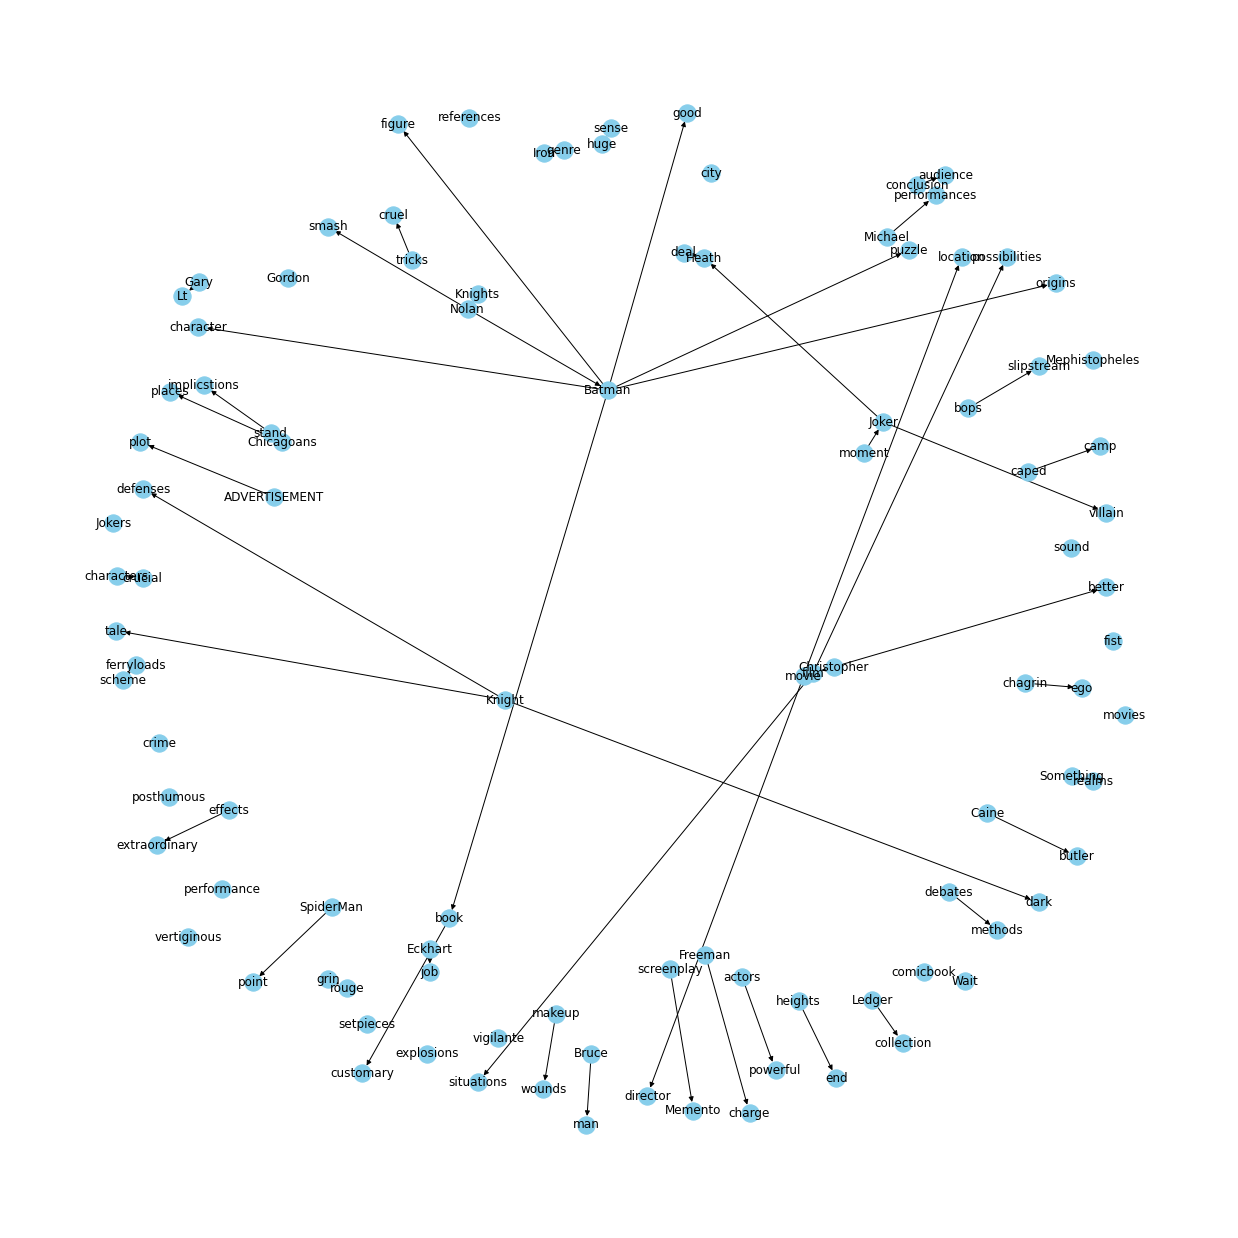

In [ ]:
graph_arr = []
for a in range(0, len(data)):
	graph_arr.append(data[a].split())
data =graph_arr

source = [i[0] for i in data]
target = [i[2] for i in data]
relations = [i[1] for i in data]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

knowledge_graph = nx.from_pandas_edgelist(kg_df, 'source', 'target', edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(17, 17))

pos = nx.spring_layout(knowledge_graph)
nx.draw(knowledge_graph, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()